In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [68]:
import pandas
import gensim

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge

import numpy as np

matplotlib.style.use('ggplot')

## 1. Read data

In [69]:
data_file = "../data/bdata.log.txt"

data = pandas.read_csv(data_file, sep = ',')

In [70]:
data.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLA-HD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLA-HD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLA-HD6,9,TBD,AMKDRFQPL,=,0.860543
3,cow,BoLA-HD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLA-HD6,9,TBD,FMKVKFEAL,=,0.957914


## 2. To one hot

In [71]:
selected_mhc = 'HLA-A*03:01'

indexes = data['mhc'][data['mhc'] == selected_mhc].index
indexes = data.iloc[indexes]['mhc'][data['peptide_length'] == 9].index
#indexes = data.index
selected_X = data['sequence'][indexes]
selected_y = data['meas'][indexes]

letters_X = selected_X.apply(list)

selected_X = pandas.DataFrame(list(letters_X))
selected_X = pandas.get_dummies(selected_X)

XX = selected_X[range(0, 20)].as_matrix() + selected_X[range(20, 40)].as_matrix() + selected_X[range(40, 60)].as_matrix() + selected_X[range(60, 80)].as_matrix() + selected_X[range(80, 100)].as_matrix() + selected_X[range(100, 120)].as_matrix() + selected_X[range(120, 140)].as_matrix() + selected_X[range(140, 160)].as_matrix() + selected_X[range(160, 180)].as_matrix()
selected_X = pandas.concat([selected_X, pandas.DataFrame(XX)], axis=1)

selected_X.shape

(5231, 200)

## 3. ml stuff

In [72]:
#normalize output
# m = selected_y.mean()
# d = selected_y.max() - selected_y.min()
# selected_y = (selected_y - m) / d

# train/test split
random_number = 52
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y,
                                                    test_size = 0.33, random_state = random_number)

In [73]:
def ridge_regression(X, y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    #Return the result in pre-defined format
    rss = sum((y_pred - y)**2)
    return rss, ridgereg.intercept_, ridgereg

In [74]:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2]

n = 6

rss = [0] * n
intercept = [0] * n
predictors = [0] * n

for i in range(n):
    rss[i], intercept[i], predictors[i] = ridge_regression(X_train, y_train, alpha_ridge[i])

In [75]:
# predict test data

test_rss = [0] * n
for i in range(n):
    m_pred = predictors[i]
    test_pred = m_pred.predict(X_test)
    test_rss[i] = sum((test_pred - y_test)**2)
    
    print '-' * 10
    print "alpha = ", alpha_ridge[i]
    print "train rss = ", rss[i]
    print "test rss = ", test_rss[i]
    
m_pred = predictors[5]
test_pred = m_pred.predict(X_test)

----------
alpha =  1e-15
train rss =  88.9680144288
test rss =  48.7164963496
----------
alpha =  1e-10
train rss =  88.9680144288
test rss =  48.7164963494
----------
alpha =  1e-08
train rss =  88.9680144288
test rss =  48.7164963378
----------
alpha =  0.0001
train rss =  88.9680151731
test rss =  48.7163790007
----------
alpha =  0.001
train rss =  88.968088723
test rss =  48.7153589064
----------
alpha =  0.01
train rss =  88.9753067544
test rss =  48.7086515093


In [76]:
test_pred = pandas.DataFrame(test_pred)

In [77]:
y_test = pandas.DataFrame(y_test)

In [78]:
test_pred['1'] = np.array(y_test)

In [79]:
test_pred.corr()

,0,1
0,1.000000,0.757778
1,0.757778,1.000000


(array([  3.,   8.,  13.,  11.,  63.,  83.,  15.,   2.,   1.,   1.]),
 array([-0.20234507, -0.16311412, -0.12388318, -0.08465224, -0.0454213 ,
        -0.00619035,  0.03304059,  0.07227153,  0.11150247,  0.15073342,
         0.18996436]),
 <a list of 10 Patch objects>)

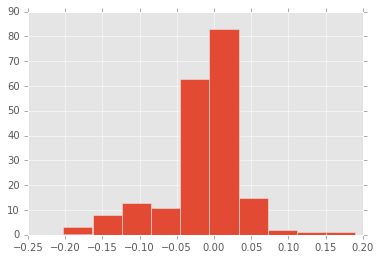

In [80]:
plt.hist(list(m_pred.coef_))